# Tutorial

## Load Environment

First, load necessary modules to be load in the following steps.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Load Hills

We could load hills from `HILLS` produced by Plumed, to do more analysis. 
Here, we just use the examples provided by V. Spiwok, 
which is trajectories of Alanine Dipeptide in water with 1, 2 or 3 Ramachandran angles, respectively.

In [2]:
from metadynminer.hills import Hills

In [4]:
#load hills
h1 = Hills(name="../tests/data/hills/acealanme1d", periodic=[True], cv_per=[[-np.pi, np.pi]])
h2 = Hills(name="../tests/data/hills/acealanme", periodic=[True,True], cv_per=[[-np.pi, np.pi], [-np.pi, np.pi]])
h3 = Hills(name="../tests/data/hills/acealanme3d", periodic=[True,True,True], cv_per=[[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]])

## Sum Hills using `Fes`

We could just use `metadynminer.fes` to sum the hills to get the Free Energy Surface (FES).
For here, there are two approaches. One is the `fast` approach, quickly do the sum in lack of accuracy.
The other is the `original` approach, just do the same as `plumed sum_hills` command.

For example, here we just use the fast approach to draw the FES of `acealanme` (with 2 CVs).

Constructing FES: 100%|██████████| 30000/30000 [00:04<00:00, 6978.45it/s]


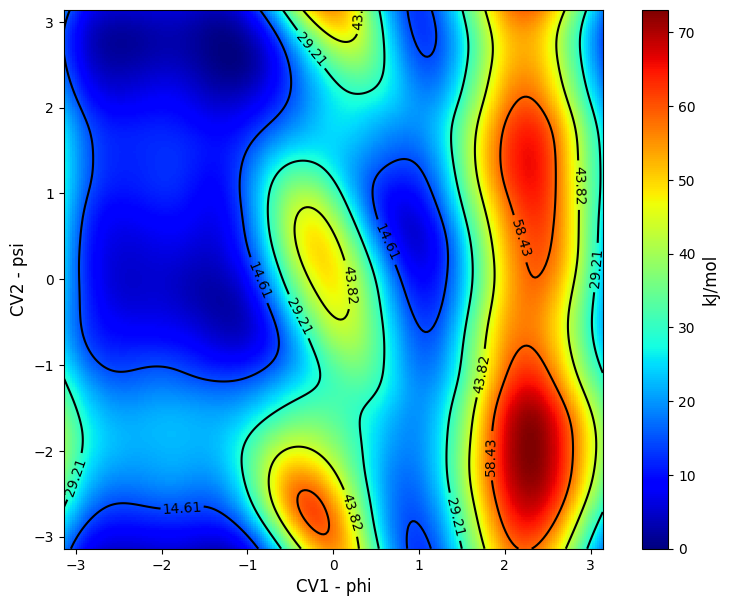

In [6]:
from metadynminer.fes import Fes

# do sum_hills
fes = Fes(h2, resolution=256)
# plot the FES
fes.plot()

We then use the original way to do the same thing, showing a significant slow down in the workflow.

Constructing FES: 100%|██████████| 65536/65536 [00:36<00:00, 1780.90it/s]


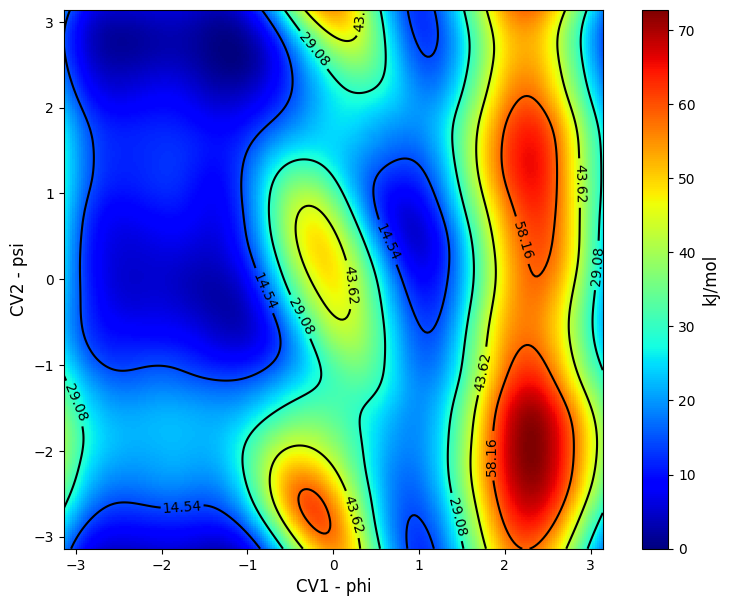

In [7]:
# do sum_hills
fes_original = Fes(h2, resolution=256, original=True)
# plot the FES
fes_original.plot()

Both algorithms could reach similar pattern of FES. The following is the comparison in detail.

In [3]:
#prepare FES
metadynminer_cv1_fast = Fes(h1, resolution=256, original=False).fes.T
#np.savetxt("metadynminer_cv1_fast.txt", metadynminer_cv1_fast, delimiter=" ")
metadynminer_cv1_original = Fes(h1, resolution=256, original=True).fes.T
#np.savetxt("metadynminer_cv1_original.txt", metadynminer_cv1_original, delimiter=" ")
metadynminer_cv2_fast = Fes(h2, resolution=256, original=False).fes.T
#np.savetxt("metadynminer_cv2_fast.txt", metadynminer_cv2_fast, delimiter=" ")
metadynminer_cv2_original = Fes(h2, resolution=256, original=True).fes.T
#np.savetxt("metadynminer_cv2_original.txt", metadynminer_cv2_original, delimiter=" ")
metadynminer_cv3_fast = Fes(h3, resolution=64, original=False).fes.T
#np.savetxt("metadynminer_cv3_fast.txt", metadynminer_cv3_fast.reshape(metadynminer_cv3_fast.shape[0], -1), delimiter=" ")
metadynminer_cv3_original = Fes(h3, resolution=64, original=True).fes.T
#np.savetxt("metadynminer_cv3_original.txt", metadynminer_cv3_original.reshape(metadynminer_cv3_original.shape[0], -1), delimiter=" ")

#prepare plumed FES
#os.system('plumed sum_hills --hills "./acealanme1d" --bin 256 --outfile plumed_acealanme1d.da')
#os.system('plumed sum_hills --hills "./acealanme" --bin 256,256 --outfile plumed_acealanme.da')
#os.system('plumed sum_hills --hills "./acealanme3d" --bin 256,256,256 --outfile plumed_acealanme3d.da')

#load plumed FES
plumed1 = np.loadtxt("plumed_acealanme1d.dat")
plumed1 = np.reshape(plumed1[:,1], (256))
plumed1 = plumed1 - np.min(plumed1)

plumed2 = np.loadtxt("plumed_acealanme.dat")
plumed2 = np.reshape(plumed2[:,2], (256,256))
plumed2 = plumed2 - np.min(plumed2)

plumed3 = np.loadtxt("plumed_acealanme3d_64.dat")
plumed3 = np.reshape(plumed3[:,3], (64,64,64))
plumed3 = plumed3 - np.min(plumed3)

#compare
mean_error_limit_original = 1e-3
mean_error_limit_fast = 1

max_error_limit_original = 1e-2
max_error_limit_fast = 4

compare_plumed = [plumed1, plumed2, plumed3]
compare_mm_fast = [metadynminer_cv1_fast, 
                   metadynminer_cv2_fast, 
                   metadynminer_cv3_fast]
compare_mm_original = [metadynminer_cv1_original,
                       metadynminer_cv2_original,
                       metadynminer_cv3_original]

for cv in range(len(compare_plumed)):
    mean_error = np.mean(compare_plumed[cv]-compare_mm_fast[cv])
    max_error = np.max(np.abs(compare_plumed[cv]-compare_mm_fast[cv]))

    if np.abs(mean_error) < mean_error_limit_fast:
        print(f"Algorithm: Fast, CV = {cv+1}: \tPASSED, mean of errors = {mean_error}.")
    else:
        print(f"Algorithm: Fast, CV = {cv+1}: \tFAILED, mean of errors = {mean_error}.")

    if max_error < max_error_limit_fast:
        print(f"Algorithm: Fast, CV = {cv+1}: \tPASSED, max error = {max_error}.")
    else:
        print(f"Algorithm: Fast, CV = {cv+1}: \tFAILED, max error = {max_error}.")

    mean_error = np.mean(compare_plumed[cv]-compare_mm_original[cv])
    max_error = np.max(np.abs(compare_plumed[cv]-compare_mm_original[cv]))

    if np.abs(mean_error) < mean_error_limit_original:
        print(f"Algorithm: Original, CV = {cv+1}: \tPASSED, mean of errors = {mean_error}.")
    else:
        print(f"Algorithm: Original, CV = {cv+1}: \tFAILED, mean of errors = {mean_error}.")

    if max_error < max_error_limit_original:
        print(f"Algorithm: Original, CV = {cv+1}: \tPASSED, max error = {max_error}.")
    else:
        print(f"Algorithm: Original, CV = {cv+1}: \tFAILED, max error = {max_error}.")

Constructing FES: 100%|██████████| 262144/262144 [03:31<00:00, 1240.29it/s]


Algorithm: Fast, CV = 1: 	PASSED, mean of errors = -0.12706082548508563.
Algorithm: Fast, CV = 1: 	PASSED, max error = 0.888422015761293.
Algorithm: Original, CV = 1: 	PASSED, mean of errors = -1.5488321736256694e-10.
Algorithm: Original, CV = 1: 	PASSED, max error = 6.583604772458784e-10.
Algorithm: Fast, CV = 2: 	PASSED, mean of errors = -0.16706817317908657.
Algorithm: Fast, CV = 2: 	PASSED, max error = 1.5483647841175028.
Algorithm: Original, CV = 2: 	PASSED, mean of errors = -2.691467101273437e-11.
Algorithm: Original, CV = 2: 	PASSED, max error = 5.254747748040245e-10.
Algorithm: Fast, CV = 3: 	PASSED, mean of errors = -0.9922609552379945.
Algorithm: Fast, CV = 3: 	FAILED, max error = 8.30947769627467.
Algorithm: Original, CV = 3: 	PASSED, mean of errors = -4.212892770099133e-10.
Algorithm: Original, CV = 3: 	PASSED, max error = 9.213465546054067e-10.


Text(0.5, 1.0, 'Fast')

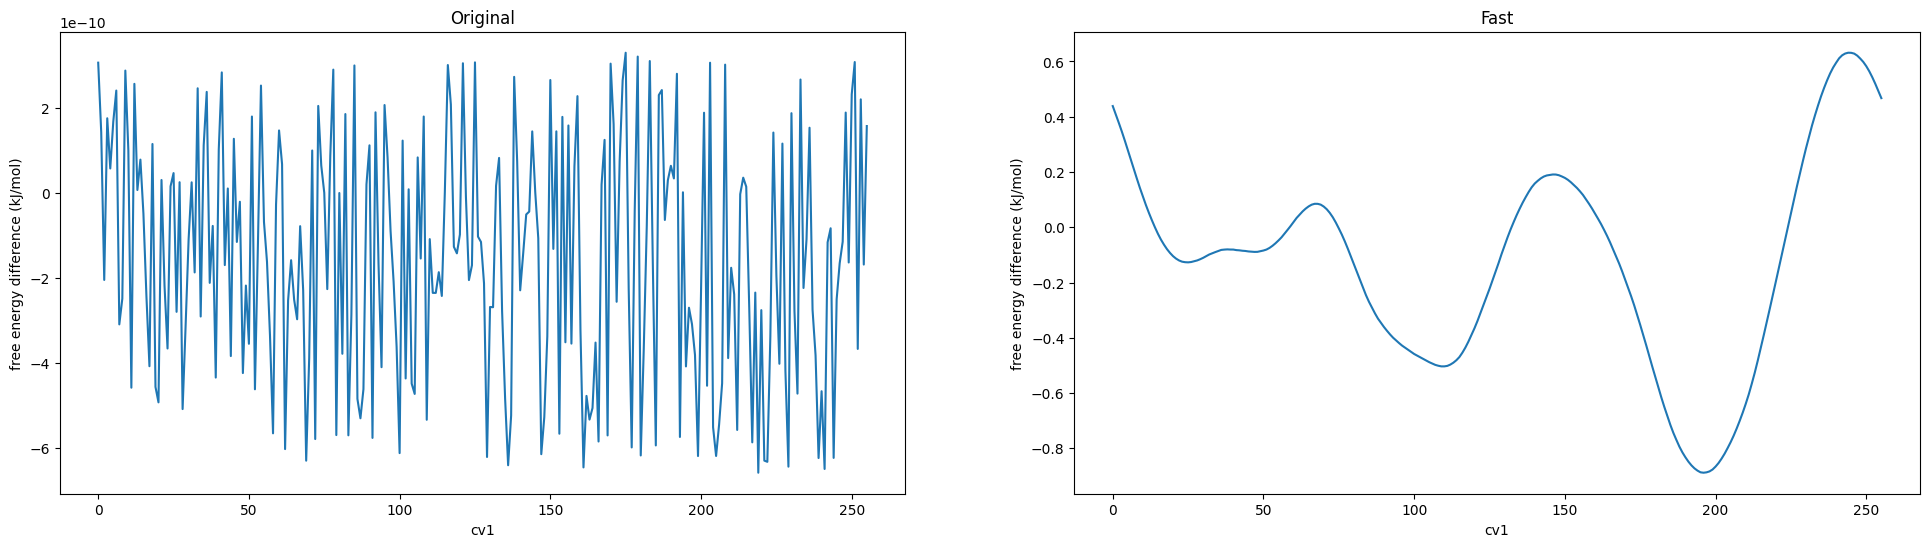

In [4]:
plt.figure(figsize=(24,6))
plt.subplot(121)
plt.plot(range(256), (plumed1-metadynminer_cv1_original))
plt.xlabel('cv1')
plt.ylabel('free energy difference (kJ/mol)')
plt.title("Original")
plt.subplot(122)
plt.plot(range(256), (plumed1-metadynminer_cv1_fast))
plt.xlabel('cv1')
plt.ylabel('free energy difference (kJ/mol)')
plt.title("Fast")

Text(0.5, 1.0, 'Fast')

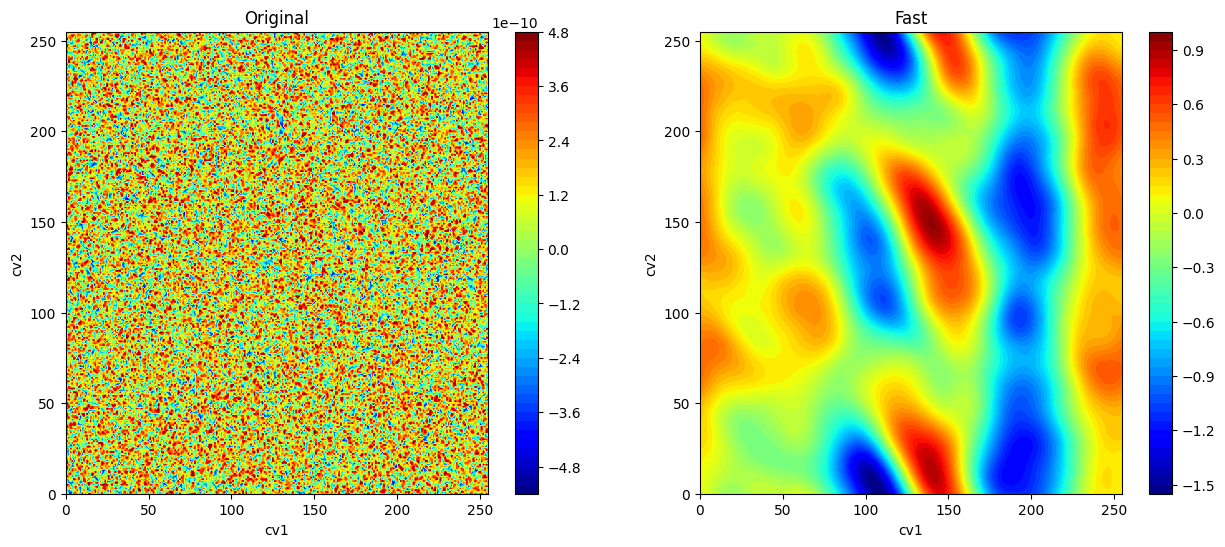

In [5]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.contourf(range(256), range(256), (plumed2-metadynminer_cv2_original), levels=50, cmap="jet")
plt.xlabel('cv1')
plt.ylabel('cv2')
plt.colorbar()
plt.title("Original")
plt.subplot(122)
plt.contourf(range(256), range(256), (plumed2-metadynminer_cv2_fast), levels=50, cmap="jet")
plt.xlabel('cv1')
plt.ylabel('cv2')
plt.colorbar()
plt.title("Fast")

## Find local minima

We could then use `Minima` to analyze the FES acquired, and to label them in the plot.

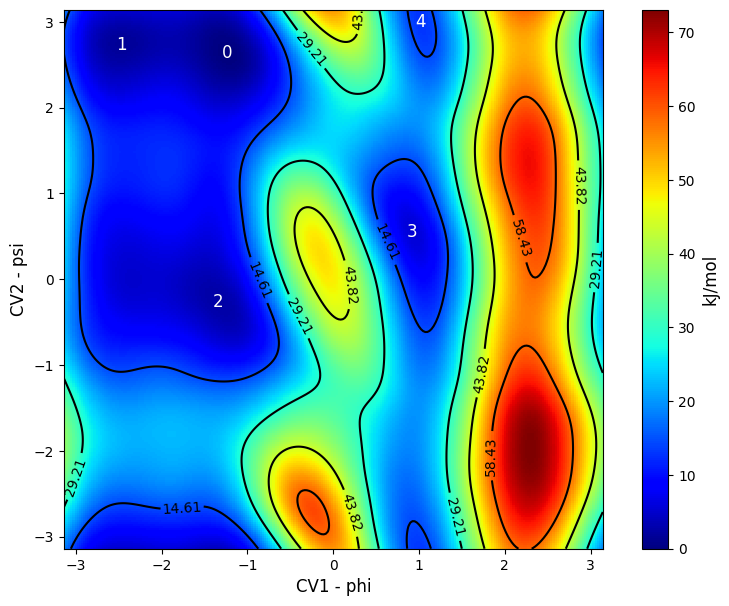

In [8]:
from metadynminer.minima import Minima

minima = Minima(fes)
# plot the minimas
minima.plot()

Local minima are stored in `pandas.DataFrame`, as shown in below.

In [9]:
minima.minima

,Minimum,free energy,CV1bin,CV2bin,CV1 - phi,CV2 - psi
0,0,0.000000,77.0,235.0,-1.239456,2.638447
1,1,1.630160,27.0,239.0,-2.466641,2.736622
2,2,2.526665,73.0,117.0,-1.337631,-0.257709
3,3,5.591042,165.0,150.0,0.920388,0.552233
4,4,12.878739,169.0,250.0,1.018563,3.006602


## Free Energy Time-dependent Profile

We could draw the time-dependent profile of free energies of local minima from `FEProfile`.

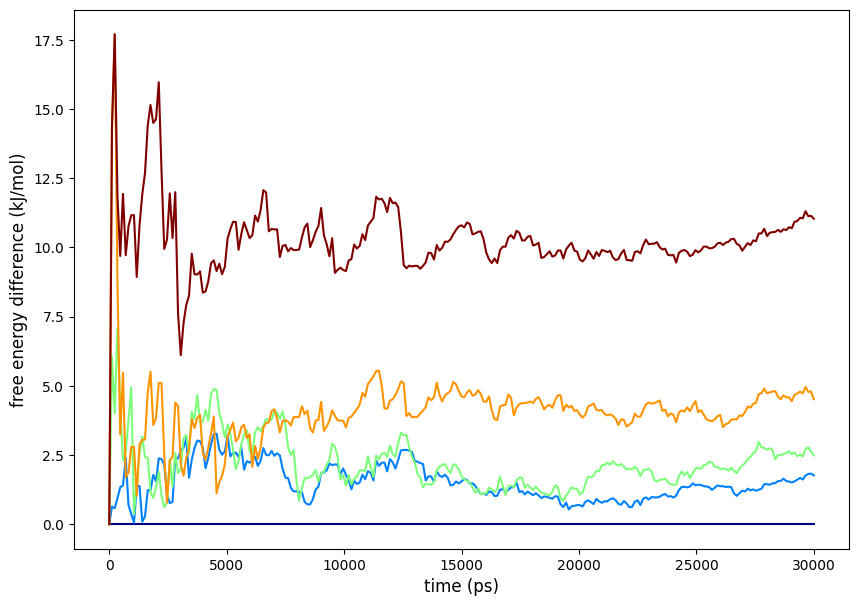

In [10]:
from metadynminer.profile import FEProfile
fe_profile = FEProfile(minima, h2)
fe_profile.plot()